In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.io
from datetime import datetime, timedelta
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import DeformConv2d
import cv2
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

warnings.filterwarnings("ignore", category=UserWarning, message=".*iCCP:.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*Corrupt JPEG data:.*")

# Set the PYTHONWARNINGS environment variable to ignore warnings
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
data = scipy.io.loadmat('/kaggle/input/imdb-wiki-faces/wiki.mat')
data = data['wiki'][0]

gender = data[0][3][0]
file_path = data[0][2][0]

In [4]:
df = pd.DataFrame({'directory': file_path, 'gender': gender})
df['directory'] = df['directory'].astype(str).str.strip("'[]'")
df = df[df['directory'].str.startswith(('00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18'))]
df[['dob', 'photo_taken']] = df['directory'].str.extract(r'_(\d{4}-\d{2}-\d{2})_(\d{4})\.jpg')
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['photo_taken'] = pd.to_datetime(df['photo_taken'], errors='coerce')

# Calculate the age of the person
df['age'] = (df['photo_taken'] - df['dob']).dt.days // 365
df.drop(df[['dob', 'photo_taken']], axis=1, inplace=True)

prefixes = {str(i).zfill(2): f"../input/imdb-wiki-faces/{str(i).zfill(2)}/" for i in range(19)}

# Function to update the 'directory' column based on prefixes
def update_directory(row):
    for prefix, path in prefixes.items():
        if row.startswith(prefix):
            return path + row
    return row

# Apply the update_directory function to the 'directory' column
df['directory'] = df['directory'].apply(update_directory)

df = df.dropna()
df = df[(df['age'] > 0) & (df['age'] <= 100)]
df.head()

,directory,gender,age
0,../input/imdb-wiki-faces/17/17/10000217_1981-0...,1.0,27.0
2,../input/imdb-wiki-faces/12/12/100012_1948-07-...,1.0,59.0
4,../input/imdb-wiki-faces/16/16/10002116_1971-0...,0.0,40.0
5,../input/imdb-wiki-faces/02/02/10002702_1960-1...,0.0,51.0
8,../input/imdb-wiki-faces/13/13/10004113_1946-0...,1.0,60.0


In [5]:
print('[+] number of images:', len(df))
print('[+] unique values of Age:')
print(df.age.unique())
print('[+] unique values of Gender:')
print(df.gender.unique())

[+] number of images: 10961
[+] unique values of Age:
[ 27.  59.  40.  51.  60.  71.  50.  56.  32.  61.  31.  30.  28.  66.
  26.  23.  24.  58.  37.  21.  62.  41.  44.  42.  38.  47.  46.  39.
  76.  53.  25.  34.  15.  19.  29.  16.  49.  22.  20.  35.  43.  65.
  18.  74.  54.  63.  82.  55.  36.  87.  45.  75.  14.  83.  48.  33.
  70.  72.  52.  90.  78.  79.  92.  77.  73.  69.  17.  64.  57.  67.
  68.  12.  93.  86.  88.  85.  98.  13.   7.   6.  11.  81.  80.   4.
   1.  91. 100.   3.  84.  94.   5.  10.  97.  89.   2.  99.   8.   9.
  96.]
[+] unique values of Gender:
[1. 0.]


In [6]:
def map_age_to_group(age):
    age_groups = {
        '0-3': 0, '4-8': 1, '9-14': 2, '15-20': 3, '21-30': 4, '31-36': 5,
        '37-45': 6, '46-53': 7, '54-59': 8, '60+': 9
    }
    if 0 <= age <= 3:
        return age_groups['0-3']
    elif 4 <= age <= 8:
        return age_groups['4-8']
    elif 9 <= age <= 14:
        return age_groups['9-14']
    elif 15 <= age <= 20:
        return age_groups['15-20']
    elif 21 <= age <= 30:
        return age_groups['21-30']
    elif 31 <= age <= 36:
        return age_groups['31-36']
    elif 37 <= age <= 45:
        return age_groups['37-45']
    elif 46 <= age <= 53:
        return age_groups['46-53']
    elif 54 <= age <= 59:
        return age_groups['54-59']
    else:
        return age_groups['60+']

df['age'] = df['age'].apply(map_age_to_group)
df = df[['directory', 'age', 'gender']]

# Create a function to filter out image files with issues
def file_exists(file_path):
    img = cv2.imread(file_path)
    if img is None:
        return False
    else:
        return os.path.exists(file_path)

# Apply the function to the 'directory' column and create a mask of existing files
mask = df['directory'].apply(file_exists)
# Filter the DataFrame to keep only rows with existing files
df = df[mask]

# Reset the index if needed
df = df.reset_index(drop=True)

df

libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: cHRM: inconsistent chromaticities
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
Corrupt JPEG data: 837 extraneous bytes before marker 0xd9
lib

,directory,age,gender
0,../input/imdb-wiki-faces/17/17/10000217_1981-0...,4,1.0
1,../input/imdb-wiki-faces/12/12/100012_1948-07-...,8,1.0
2,../input/imdb-wiki-faces/16/16/10002116_1971-0...,6,0.0
3,../input/imdb-wiki-faces/02/02/10002702_1960-1...,7,0.0
4,../input/imdb-wiki-faces/13/13/10004113_1946-0...,9,1.0
...,...,...,...
10943,../input/imdb-wiki-faces/04/04/9996804_1943-01...,4,1.0
10944,../input/imdb-wiki-faces/09/09/9996809_1939-07...,5,1.0
10945,../input/imdb-wiki-faces/17/17/9996817_1938-12...,4,1.0
10946,../input/imdb-wiki-faces/09/09/9998109_1972-12...,6,1.0


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227, 227)), # Same hyperparameter as the paper "Age and Gender Classification using Convolutional Neural Networks"
])

class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.df.iloc[idx,0])
        if img is None:
            raise FileNotFoundError(f"Image not found for index {idx}")
        img = self.transform(img).to(device)
        age = torch.tensor(self.df.iloc[idx,1]).to(device)
        gender = torch.tensor(self.df.iloc[idx,2]).to(device)
        return img, age, gender

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


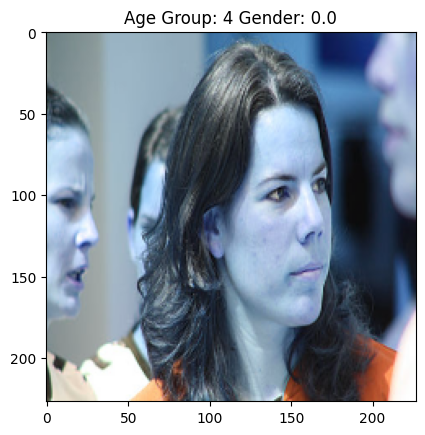

In [8]:
dataset_temp = CustomDataset(df, transform=transform)
dataloader_temp = DataLoader(dataset_temp, batch_size=16, shuffle=True)

data_iter = iter(dataloader_temp)
image, label_age, label_gender = next(data_iter)

plt.imshow(torch.Tensor.cpu(image[0].permute(1, 2, 0)))
plt.title(f'Age Group: {label_age[0]} Gender: {label_gender[0]}')
plt.show()

In [9]:
# Build Model
class GenderAgeCNNModel(nn.Module):
    def __init__(self):
        super(GenderAgeCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, stride=1)
        self.p1 = nn.MaxPool2d(2, 2)  # Max pooling over a (2, 2) window
        self.conv2 = nn.Conv2d(64, 64, 5, stride=1) 
        self.p2 = nn.MaxPool2d(2, 2)  # Max pooling over a (2, 2) window
        self.conv3 = nn.Conv2d(64, 128, 5, stride=1)
        self.p3 = nn.MaxPool2d(2, 2)  # Max pooling over a (2, 2) window
        self.flatten = nn.Flatten()
        self.d1 = nn.Linear(128 * 24 * 24, 256)
        self.d2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.2)
        self.outputGender = nn.Linear(128, 1)
        self.outputAge = nn.Linear(128, 10)
        
    def forward(self, x):
        conv1 = torch.relu(self.conv1(x))
        p1 = self.p1(conv1)
        conv2 = torch.relu(self.conv2(p1))
        p2 = self.p2(conv2)
        conv3 = torch.relu(self.conv3(p2))
        p3 = self.p3(conv3)
        flatten = self.flatten(p3)
        d1 = torch.relu(self.d1(flatten))
        dropout1 = self.dropout(d1)
        d2 = torch.relu(self.d2(dropout1))
        dropout2 = self.dropout(d2)
        outGender = torch.sigmoid(self.outputGender(dropout2))
        outAge = torch.softmax(self.outputAge(dropout2), dim=1)
        return outGender, outAge

In [10]:
def train(model, train_dataloader, val_dataloader, num_epochs):
    train_gender_acc = []
    train_age_acc = []
    train_gender_loss = []
    train_age_loss = []
    val_gender_acc = []
    val_age_acc = []
    val_gender_loss = []
    val_age_loss = []
    
    for epoch in range(num_epochs):
        model.train()  # Set the model in training mode
        
        train_gender_losses = 0
        train_age_losses = 0
        output_gender_wrong = 0
        output_age_correct = 0
        
        num_batches = len(train_dataloader)
        size = len(train_dataloader.dataset)
        
        for i, data in enumerate(train_dataloader):
            inputs, labels_age, labels_gender = data
            labels_gender = labels_gender.unsqueeze(1).float()
            optimizer.zero_grad()  # Zero the parameter gradients
            
            # Forward pass
            outputGender, outputAge = model(inputs)
            
            # Compute the loss
            loss_gender = criterion_gender(outputGender, labels_gender)
            loss_age = criterion_age(outputAge, labels_age)
            loss = loss_gender + loss_age
            
            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            
            # Save statistics
            train_gender_losses += loss_gender.item()
            train_age_losses += loss_age.item()
            output_gender_wrong += torch.sum(torch.not_equal(outputGender > 0.5, labels_gender))
            output_age_correct += (outputAge.argmax(dim=1) == labels_age).sum().item()
        
        train_gender_losses /= num_batches
        train_age_losses /= num_batches
        train_gender_correct = (size - output_gender_wrong)/size # Calculate the accuracy for gender
        train_age_correct = output_age_correct/size
        
        train_gender_acc.append(train_gender_correct)
        train_gender_loss.append(train_gender_losses)
        train_age_acc.append(train_age_correct)
        train_age_loss.append(train_age_losses)
        

        output_gender_wrong = 0
        output_age_correct = 0
        val_age_losses = 0
        val_gender_losses = 0
        
        num_batches = len(val_dataloader)
        size = len(val_dataloader.dataset)
        
        for i, data in enumerate(val_dataloader):
            size = len(val_dataloader.dataset)
            inputs, labels_age, labels_gender = data
            labels_gender = labels_gender.unsqueeze(1).float()
            
            outputs_gender, outputs_age = model(inputs)
            loss_gender = criterion_gender(outputs_gender, labels_gender)
            loss_age = criterion_age(outputs_age, labels_age)
            loss = (loss_gender + loss_age)/2
            
            # Save statistics
            val_gender_losses += loss_gender.item()
            val_age_losses += loss_age.item()
            output_gender_wrong += torch.sum(torch.not_equal(outputs_gender > 0.5, labels_gender))
            output_age_correct += (outputs_age.argmax(dim=1) == labels_age).sum().item()
        
        val_gender_losses /= num_batches
        val_age_losses /= num_batches
        val_gender_correct = (size - output_gender_wrong)/size # Calculate the accuracy for gender
        val_age_correct = output_age_correct/size
        
        val_gender_acc.append(val_gender_correct)
        val_gender_loss.append(val_gender_losses)
        val_age_acc.append(val_age_correct)
        val_age_loss.append(val_age_losses)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy for Gender: {train_gender_correct:.4f}, Val Accuracy for Gender: {val_gender_correct:.2f}')
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy for Age: {train_age_correct:.4f}, Val Accuracy for Age: {val_age_correct:.4f}')
        
    return train_gender_acc, train_age_acc, train_gender_loss, train_age_loss, val_gender_acc, val_age_acc, val_gender_loss, val_age_loss

In [11]:
batch_size = 64

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

val_dataset = CustomDataset(df=df_test, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
train_dataset = CustomDataset(df=df_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = GenderAgeCNNModel().to(device)
criterion_gender = nn.BCELoss()
criterion_age = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_gender_acc, train_age_acc, _, _, val_gender_acc, val_age_acc, _, _ = train(model, train_dataloader, val_dataloader, 5)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 837 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: cHRM: inconsistent chromaticities
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorr

Epoch [1/5], Train Accuracy for Gender: 0.7729, Val Accuracy for Gender: 0.78
Epoch [1/5], Train Accuracy for Age: 0.3826, Val Accuracy for Age: 0.3863


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: cHRM: inconsistent chromaticities
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: cHRM: inconsistent chromaticities
Corrupt JPEG data: 837 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorre

Epoch [2/5], Train Accuracy for Gender: 0.7797, Val Accuracy for Gender: 0.78
Epoch [2/5], Train Accuracy for Age: 0.3888, Val Accuracy for Age: 0.3863


libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: cHRM: inconsistent chromaticities
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: cHRM: inconsistent chromaticities
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 837 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorre

Epoch [3/5], Train Accuracy for Gender: 0.7797, Val Accuracy for Gender: 0.78
Epoch [3/5], Train Accuracy for Age: 0.3888, Val Accuracy for Age: 0.3863


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: cHRM: inconsistent chromaticities
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: cHRM: inconsistent chromaticities
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
li

Epoch [4/5], Train Accuracy for Gender: 0.7797, Val Accuracy for Gender: 0.78
Epoch [4/5], Train Accuracy for Age: 0.3888, Val Accuracy for Age: 0.3863


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: cHRM: inconsistent chromaticities
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: cHRM: inconsistent chromaticities
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB 

Epoch [5/5], Train Accuracy for Gender: 0.7793, Val Accuracy for Gender: 0.78
Epoch [5/5], Train Accuracy for Age: 0.3888, Val Accuracy for Age: 0.3863


In [12]:
for i in range(len(train_gender_acc)):
    train_gender_acc[i] = torch.Tensor.cpu(train_gender_acc[i])
    val_gender_acc[i] = torch.Tensor.cpu(val_gender_acc[i])

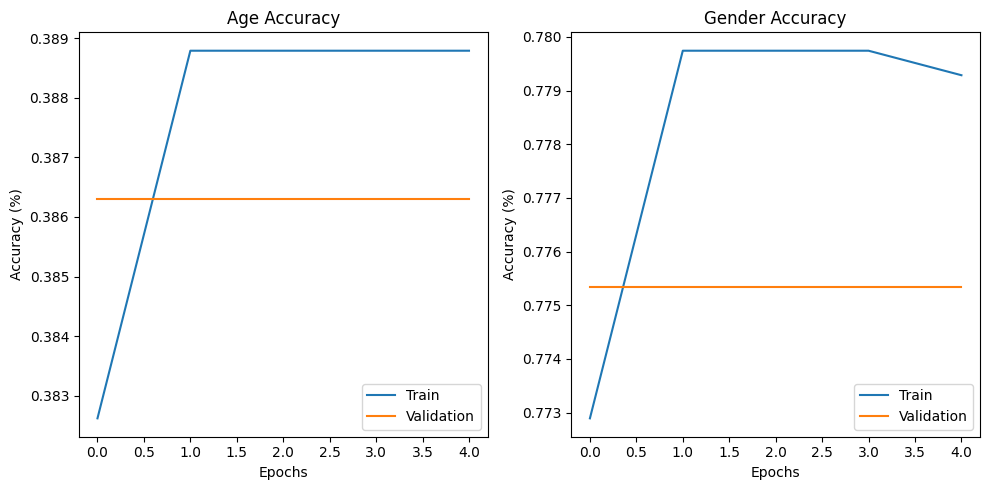

In [13]:
# Plot training and validation accuracy for age
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_age_acc, label='Train')
plt.plot(val_age_acc, label='Validation')
plt.title('Age Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot training and validation accuracy for gender
plt.subplot(1, 2, 2)
plt.plot(train_gender_acc, label='Train')
plt.plot(val_gender_acc, label='Validation')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
print("training accuracy for age:", train_age_acc)
print("training accuracy for gender:", train_gender_acc)
print("validation accuracy for age:", val_age_acc)
print("validation accuracy for gender:", val_gender_acc)

training accuracy for age: [0.3826216031057319, 0.38878739438227905, 0.38878739438227905, 0.38878739438227905, 0.38878739438227905]
training accuracy for gender: [tensor(0.7729), tensor(0.7797), tensor(0.7797), tensor(0.7797), tensor(0.7793)]
validation accuracy for age: [0.3863013698630137, 0.3863013698630137, 0.3863013698630137, 0.3863013698630137, 0.3863013698630137]
validation accuracy for gender: [tensor(0.7753), tensor(0.7753), tensor(0.7753), tensor(0.7753), tensor(0.7753)]
